In [16]:
#Libaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
import matplotlib.pyplot as plt


In [6]:
#Creating/Defining Data Loader

def create_data_loader(train_dir, test_dir, valid_dir, image_size=(299, 299), batch_size=128, limit=100):
    train_ds = keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )

    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size,
    )

    valid_ds = keras.utils.image_dataset_from_directory(
        valid_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )

    if limit:
        train_ds = train_ds.take(limit)
        test_ds = test_ds.take(limit)

    return train_ds, test_ds, valid_ds

In [12]:
#Creating/Defining Transfer Model & the architecture of the model

def create_transfer_model(input_shape, num_classes):    
    backbone = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    
#Architecture
    
    inputs = layers.Input(input_shape)
    x = keras.applications.xception.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="transfer_model")

In [13]:
#Compiling model, creating checkpoints

train_dir = 'Data/Train'
test_dir = 'Data/Test'
valid_dir = 'Data/Valid'

train_ds, test_ds, valid_ds = create_data_loader(train_dir, test_dir, valid_dir, limit=100)

checkpoint_path = "model_checkpoint.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_accuracy', 
                                             verbose=1, 
                                             save_best_only=True,
                                             mode='max')

input_shape = (299, 299, 3) 
num_classes = 4  
model = create_transfer_model(input_shape, num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Found 494 files belonging to 4 classes.
Found 283 files belonging to 4 classes.
Found 70 files belonging to 4 classes.


In [14]:
#Running the model

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,  
    callbacks=[checkpoint]
)

model.load_weights(checkpoint_path)

test_loss, test_accuracy = model.evaluate(test_ds)
print("\nTest Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2856 - loss: 1.4524 
Epoch 1: val_accuracy improved from -inf to 0.18571, saving model to model_checkpoint.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 14s/step - accuracy: 0.2864 - loss: 1.4498 - val_accuracy: 0.1857 - val_loss: 1.4902
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3452 - loss: 1.3887 
Epoch 2: val_accuracy did not improve from 0.18571
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - accuracy: 0.3393 - loss: 1.3899 - val_accuracy: 0.1714 - val_loss: 1.4675
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3357 - loss: 1.3554 
Epoch 3: val_accuracy improved from 0.18571 to 0.22857, saving model to model_checkpoint.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 13s/step - accuracy: 0.3366 - loss: 1.3555 - val_accuracy: 0.2286 - val_loss: 1.4492
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3395 - loss: 1.3435 
Epoch 4: val_accuracy improved from 0.22857 to 0.27143, saving model to model_checkpoint

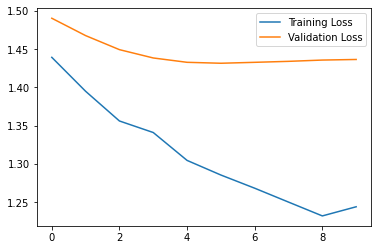

In [17]:
#Roc Curve for loss & Val Loss

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

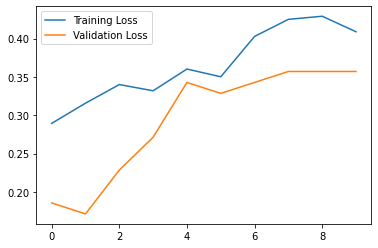

In [18]:
#ROC Curve for accuracy & Val Accuracy

plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Loss")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Loss")
plt.legend()